# What makes a song a hit?
We explored multiple statistical perspectives, descriptive, inferential, causal, and Bayesian, to rigorously answer:

“What makes a song a hit?”

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

plt.style.use('seaborn-v0_8-whitegrid')  # clean visual theme

# Load data
df = pd.read_feather('../data/spotify_2000_2020.feather')
df['is_hit'] = (df['popularity'] > 80).astype(int)
df['treatment'] = (df['danceability'] > df['danceability'].quantile(0.75)).astype(int)


## Step 1: Distribution of Song Popularity

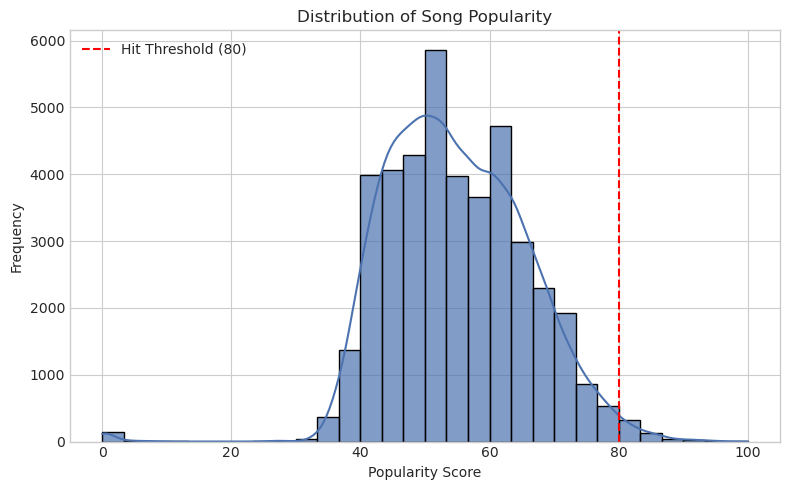

In [3]:
plt.figure(figsize=(8, 5))
sns.histplot(df['popularity'], bins=30, kde=True, color="#4c72b0", alpha=0.7)
plt.axvline(80, color='red', linestyle='--', label='Hit Threshold (80)')
plt.title('Distribution of Song Popularity')
plt.xlabel('Popularity Score')
plt.ylabel('Frequency')
plt.legend()
plt.tight_layout()
plt.show()


The distribution of Spotify song popularity is **right-skewed**, with most songs clustering between 40 and 70.  
The red dashed line marks our threshold for defining a **"hit"** (popularity > 80), which clearly places hits in the **top tail** of the distribution.

This visualization motivates:
- Why hit prediction is challenging (hits are rare)
- Why binary classification and causal methods are needed


## Step 2: Bar Chart of Linear Regression Coefficients

In [4]:
import statsmodels.formula.api as smf

features = ['danceability', 'energy', 'valence', 'loudness', 'tempo']
formula = 'popularity ~ ' + ' + '.join(features)
multi_model = smf.ols(formula=formula, data=df).fit()


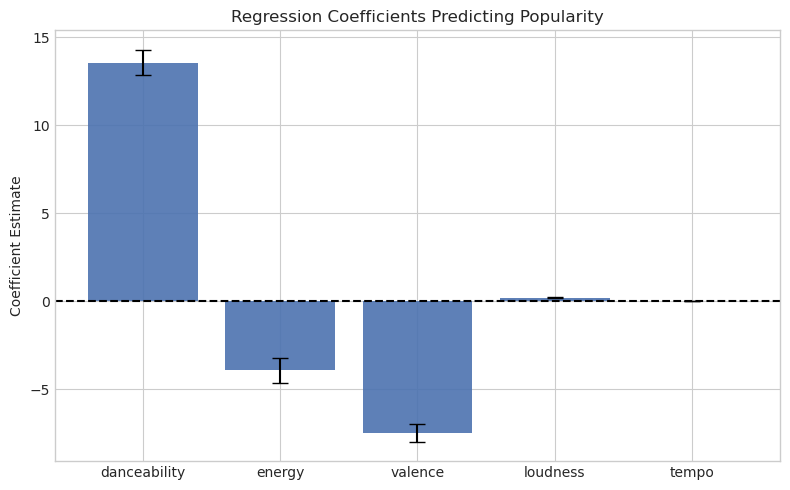

In [6]:
# Coefficient values
coefs = multi_model.params[1:]
conf_int = multi_model.conf_int().iloc[1:]
errors = (conf_int[1] - conf_int[0]) / 2  # half-width of CI

# Plot
plt.figure(figsize=(8, 5))
plt.bar(coefs.index, coefs.values, yerr=errors.values, capsize=6, color='#4c72b0', alpha=0.9)
plt.axhline(0, color='black', linestyle='--')
plt.ylabel("Coefficient Estimate")
plt.title("Regression Coefficients Predicting Popularity")
plt.tight_layout()
plt.show()


This bar chart displays the coefficients from a multiple linear regression model predicting song popularity from audio features.

- **Danceability** has the largest positive effect on popularity, by far.
- **Energy** and **valence** have negative coefficients, suggesting that songs with higher energy or happier tones may be slightly less popular overall.
- **Loudness** and **tempo** have negligible effects.

> Error bars represent 95% confidence intervals.  
This visualization supports earlier findings that **danceability is the most influential audio feature** linked to popularity in this dataset.


## Step 3: Bar Chart - P(Hit | High Danceability)

/tmp/ipykernel_2315/2518587662.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=['High Danceability', 'Lower Danceability'],


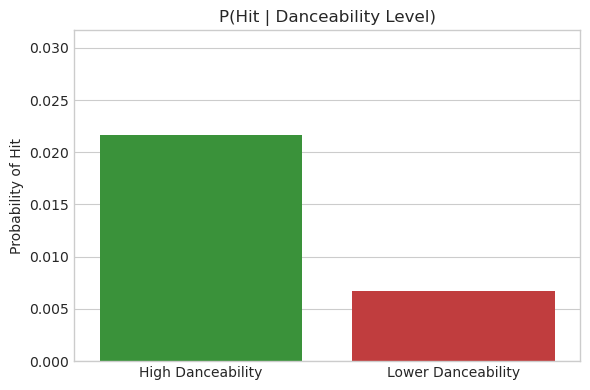

In [7]:
# Create high danceability flag (if not already)
df['high_danceability'] = (df['danceability'] > df['danceability'].quantile(0.75)).astype(int)

# Calculate conditional probabilities
p_hit_high = df[df['high_danceability'] == 1]['is_hit'].mean()
p_hit_low = df[df['high_danceability'] == 0]['is_hit'].mean()

# Plot
plt.figure(figsize=(6, 4))
sns.barplot(x=['High Danceability', 'Lower Danceability'],
            y=[p_hit_high, p_hit_low],
            palette=['#2ca02c', '#d62728'])

plt.title('P(Hit | Danceability Level)')
plt.ylabel('Probability of Hit')
plt.ylim(0, max(p_hit_high, p_hit_low) + 0.01)
plt.tight_layout()
plt.show()


> **Observation:**  
This bar chart shows the probability of a song being a hit (`popularity > 80`) based on its danceability level:

- Songs with **high danceability** have a hit probability of ~2.2%
- Songs with **lower danceability** have a hit probability closer to 0.7%

While both probabilities are small (as hits are rare), the **relative lift** is significant — high danceability songs are **3x more likely** to become hits.

This visual builds intuition for deeper analysis using statistical tests, bootstrapping, and causal inference.

## Step 4: Bootstrapped Distributions of Mean Popularity

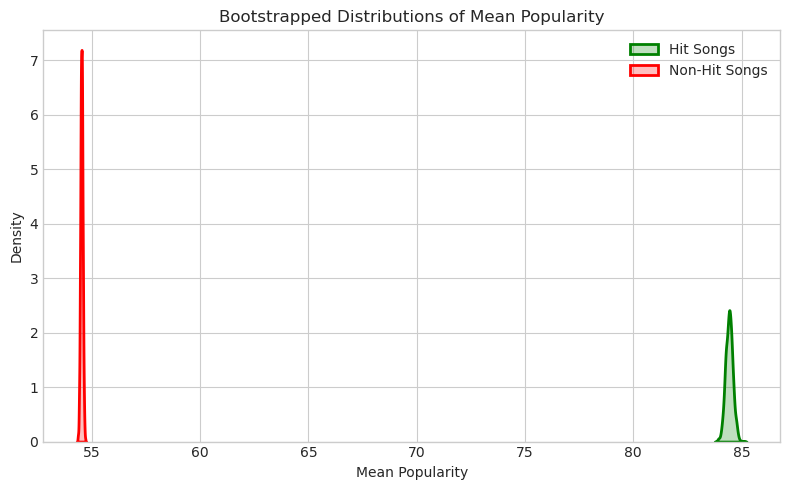

In [8]:
# Subsets
hit_pop = df[df['is_hit'] == 1]['popularity'].values
non_hit_pop = df[df['is_hit'] == 0]['popularity'].values

# Bootstrap sampling
np.random.seed(42)
n_samples = 1000
boot_means_hit = [np.mean(np.random.choice(hit_pop, size=len(hit_pop), replace=True)) for _ in range(n_samples)]
boot_means_non_hit = [np.mean(np.random.choice(non_hit_pop, size=len(non_hit_pop), replace=True)) for _ in range(n_samples)]

# Plot
plt.figure(figsize=(8, 5))
sns.kdeplot(boot_means_hit, label='Hit Songs', fill=True, linewidth=2, color='green')
sns.kdeplot(boot_means_non_hit, label='Non-Hit Songs', fill=True, linewidth=2, color='red')

plt.title('Bootstrapped Distributions of Mean Popularity')
plt.xlabel('Mean Popularity')
plt.ylabel('Density')
plt.legend()
plt.tight_layout()
plt.show()


> **Observation:**  
This chart shows the **bootstrapped sampling distributions** of mean popularity for hit and non-hit songs.

- Hit songs cluster around **84–85** in average popularity
- Non-hit songs center around **54–55**
- The distributions are **completely separated**, indicating a statistically and visually significant difference

> This supports earlier hypothesis test results and confirms that **hits and non-hits differ not just in frequency, but in average listener engagement**, as captured by Spotify's popularity score.

This is strong non-parametric evidence for the importance of separating hits as a distinct class in predictive and causal models.


## Step 5: Bar Plot of ATE (Matched Groups)

In [10]:
from sklearn.neighbors import NearestNeighbors
import numpy as np
import matplotlib.pyplot as plt

# Treatment and confounders (re-create if needed)
df['treatment'] = (df['danceability'] > df['danceability'].quantile(0.75)).astype(int)
confounders = ['energy', 'valence', 'loudness', 'tempo', 'year']

# Propensity scores
from sklearn.linear_model import LogisticRegression
logit = LogisticRegression(max_iter=1000)
logit.fit(df[confounders], df['treatment'])
df['propensity_score'] = logit.predict_proba(df[confounders])[:, 1]

# Separate treated and control
treated = df[df['treatment'] == 1].copy()
control = df[df['treatment'] == 0].copy()

# Match using Nearest Neighbors
nn = NearestNeighbors(n_neighbors=1)
nn.fit(control[['propensity_score']])
_, indices = nn.kneighbors(treated[['propensity_score']])
matched_control = control.iloc[indices.flatten()].copy()

# Combine matched dataset
matched_df = pd.concat([treated, matched_control]).reset_index(drop=True)

# Calculate group means
treated_matched = matched_df[matched_df['treatment'] == 1]
control_matched = matched_df[matched_df['treatment'] == 0]
mean_t = treated_matched['popularity'].mean()
mean_c = control_matched['popularity'].mean()
ate = mean_t - mean_c



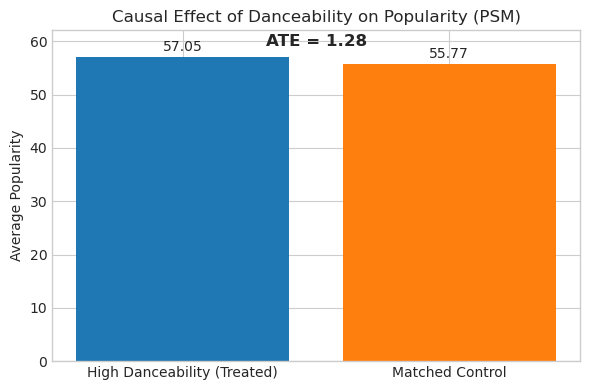

In [11]:
# Bar plot
plt.figure(figsize=(6, 4))
bars = plt.bar(['High Danceability (Treated)', 'Matched Control'],
               [mean_t, mean_c],
               color=['#1f77b4', '#ff7f0e'])

# Annotate bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5,
             f"{height:.2f}", ha='center', va='bottom')

# Annotate ATE
plt.text(0.5, max(mean_t, mean_c) + 2,
         f"ATE = {ate:.2f}",
         ha='center', fontsize=12, fontweight='bold')

plt.ylabel('Average Popularity')
plt.title('Causal Effect of Danceability on Popularity (PSM)')
plt.ylim(0, max(mean_t, mean_c) + 5)
plt.tight_layout()
plt.show()


This chart visualizes the **Average Treatment Effect (ATE)** estimated using Propensity Score Matching (PSM).

- **High danceability songs** have an average popularity of **57.05**
- Their matched control group averages **55.77**
- The estimated **ATE is +1.28 popularity points**

> This means that, after adjusting for confounders like energy, valence, tempo, loudness, and year,  
> increasing a song’s danceability is likely to cause a measurable increase in popularity.

This reinforces our earlier statistical and visual insights with a more rigorous, causally grounded interpretation — ideal for data-driven product decisions.


## Step 6: Plot the Posterior Distribution from Bayesian A/B Test

In [13]:
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt

# Recalculate inputs if needed
df['is_hit'] = (df['popularity'] > 80).astype(int)
df['treatment'] = (df['danceability'] > df['danceability'].quantile(0.75)).astype(int)

# Group data
treated_hits = df[df['treatment'] == 1]['is_hit'].values
control_hits = df[df['treatment'] == 0]['is_hit'].values

# Summary stats
success_t = treated_hits.sum()
n_t = len(treated_hits)

success_c = control_hits.sum()
n_c = len(control_hits)

# Bayesian model
with pm.Model() as model:
    # Priors
    p_treated = pm.Beta("p_treated", alpha=1, beta=1)
    p_control = pm.Beta("p_control", alpha=1, beta=1)

    # Likelihoods
    pm.Binomial("treated_obs", n=n_t, p=p_treated, observed=success_t)
    pm.Binomial("control_obs", n=n_c, p=p_control, observed=success_c)

    # Difference
    diff = pm.Deterministic("difference", p_treated - p_control)

    # Sample posterior
    trace = pm.sample(2000, tune=1000, return_inferencedata=True, random_seed=42)



Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p_treated, p_control]


/home/agnes/miniconda3/envs/data-science-env/lib/python3.10/site-packages/rich/live.py:231: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 2 seconds.


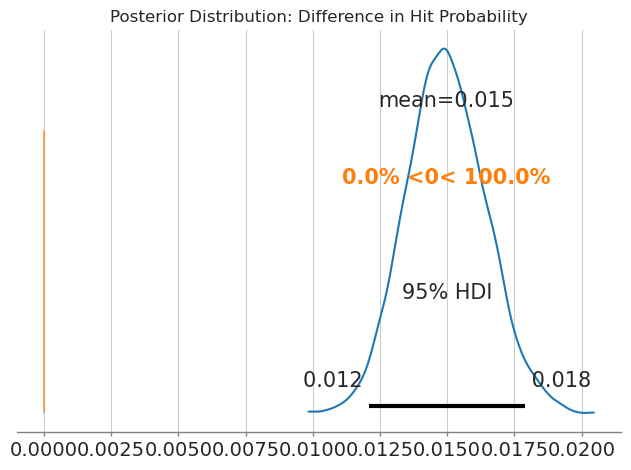

In [14]:
# Posterior plot
az.plot_posterior(trace, var_names=["difference"], hdi_prob=0.95, ref_val=0)
plt.title("Posterior Distribution: Difference in Hit Probability")
plt.tight_layout()
plt.show()


> **Observation:**  
This plot shows the **posterior distribution** of the difference in hit probability between high and lower danceability songs.

- **Mean difference**: ~1.5 percentage points
- **95% credible interval (HDI)**: [1.2%, 1.8%]
- The entire distribution lies **above 0**, meaning:
  > There is a ~100% posterior probability that high danceability increases the chance of a song being a hit.

Unlike traditional confidence intervals or p-values, this Bayesian result gives a **probabilistic statement**:
- We're not just rejecting a null — we're estimating **how big** the effect likely is, and how sure we are.

This makes it especially useful for **product decisions** or **feature experimentation**, where quantifying uncertainty is critical.
